# Chapter 6

In [41]:
import os
os.chdir("/workspaces/BAIT")
from figures.fig_utils import *


import numpy as np
import pandas as pd
import torch
import seaborn as sns
from analysis.results_utils import *


df = load_csv()
# df = df.sort_values(by="accuracy")
df = df.sort_values(by="final_sparsity")
# df["final_sparsity"] = df["final_sparsity"].apply(lambda x: f"{x:.3f}")



def plot_perf(data, transform_names=True, x="final_sparsity", y="accuracy", hue="type_short", col="phase_0_strategy", height=4, aspect=.6, col_order= ["rand", "mag", "grasp", "snip", "synflow"], **kwargs):
    # data["style"] = "pruned"
    kwargs.update({
        "x":x, "y":y, "hue":hue, "col":col, "height":height, "aspect": aspect, "col_order": col_order
        })
    if transform_names:
        data = replace_typeshort(data)
        data = replace_algo(data)
        data = prettify_names(data)
        kwargs["col_order"] = [transform_algos(co) for co in col_order] if col_order else col_order
        kwargs = {k: pretty_names.get(v, v) if isinstance(v, str) else v for k, v in kwargs.items()}
        
    g = sns.relplot(data=data, palette="tab10", kind="line",err_style="bars", **kwargs)
    g.set(
        xscale="log"
    )
    try:
        for ax in g.axes.flatten():
            ax.set_title(ax.get_title().split("=")[1])
    except:
        pass
    
    return g


## Baseline

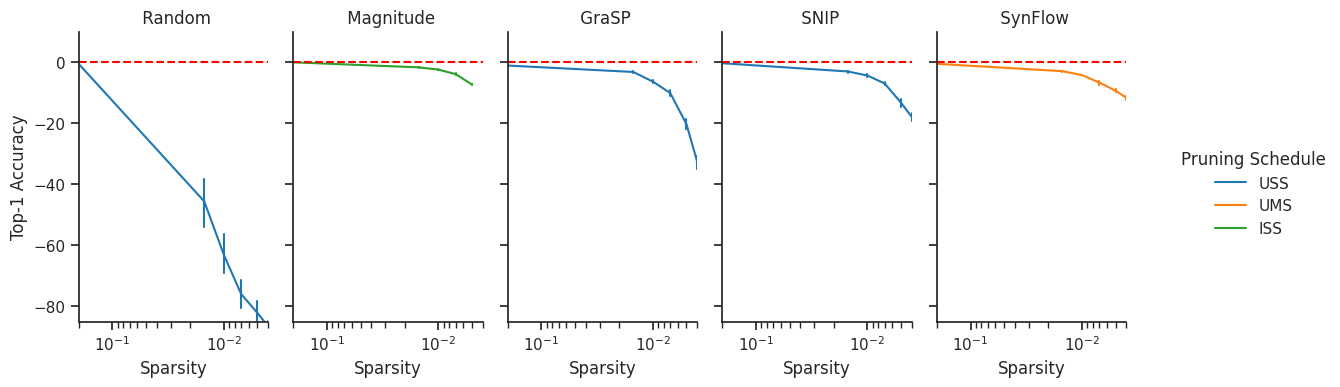

In [60]:
# def filter_baselines(row):
import math
import matplotlib.pyplot as plt
def baseline_query():
    mapping = {
        "rand": "o1",
        "mag": "i1",
        "snip": "o1",
        "grasp": "o1",
        "synflow": "o10",
    }
    return " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])


df_bl = df.query(baseline_query()).query("init_strategy == 'standard'")

df_fullytrained = df.query('final_sparsity == 1.0')[["init_strategy", "accuracy", "total_iterations", "total_epochs"]].groupby(["init_strategy"]).mean()

df_bl = df_bl.merge(df_fullytrained, on=["init_strategy"], how="inner", suffixes=((None, "_fullyTrained")))
df_bl["absolute_accuracy"] = df_bl["accuracy"]
df_bl["accuracy"] = df_bl["accuracy"] - df_bl["accuracy_fullyTrained"]


import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)

# g = sns.relplot(data=prettify_names(df_bl), x=pretty_names["final_sparsity"], y=pretty_names["accuracy"], palette="tab10", kind="line",err_style="bars", col=pretty_names["phase_0_strategy"], hue="type_short")
g = plot_perf(df_bl, facet_kws={"margin_titles":True, "despine":False})
for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(0.2, 0.004),
    ylim=(-85, 10),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, "5_baseline_accuracy_drop")


## Ablation study

In [24]:
x = "standard_o1_SNIPRandStacked_0.2_1_20220530131232127842"
int(x.rsplit("_", 2)[-1][:8])

20220530

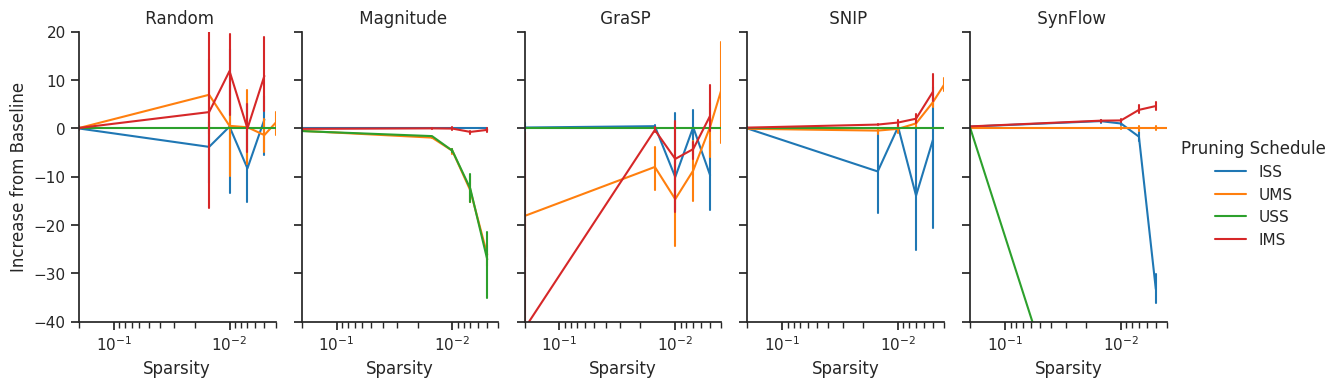

In [32]:
INCREASE_COL = "Increase from Baseline"

df = load_csv()
df_as = df.query("init_strategy == 'standard'")

# df_as["date"] = df_as["file"].apply(lambda x: int(x.rsplit("_", 2)[-1][:8]))

# df_as = df_as.query("date < 20220525")
def baseline_query():
    mapping = {
        "rand": "o1",
        "mag": "i1",
        "snip": "o1",
        "grasp": "o1",
        "synflow": "o10",
    }
    return " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])

df_as = df_as.merge(df.query(baseline_query()).query("init_strategy == 'standard'"), on=["init_strategy", "final_sparsity", "phase_0_strategy", "repeat_nr"], how="inner", suffixes=((None, "_baseline")))

df_as[INCREASE_COL] = df_as["accuracy"] -df_as["accuracy_baseline"]

g = plot_perf(df_as, y=INCREASE_COL)
g.set(
    xscale="log",
    ylim=(-40, 20),
    xlim=(0.2, 0.004)
)
savefig(g, "5_ablation_study")

## Best is

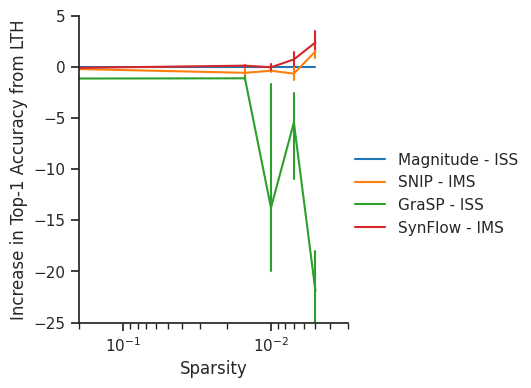

In [36]:
df = load_csv()
def baseline_query():
    mapping = {
        # "rand": "o1",
        "mag": "i1",
        "snip": "i10",
        "grasp": "i1",
        "synflow": "i10",
    }
    return " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])

df_besto = df.query(baseline_query()).query("init_strategy == 'standard'")

df_besto = df_besto.merge(df.query("phase_0_strategy == 'mag' and type_short == 'i1'").query("init_strategy == 'standard'"), on=["init_strategy", "final_sparsity", "repeat_nr"], suffixes=(None, "_lth"))

INCREASE_COL = "Increase in Top-1 Accuracy from LTH"

df_besto[INCREASE_COL] = df_besto["accuracy"] - df_besto["accuracy_lth"]

g = plot_perf(df_besto, col=None, hue=df_besto["phase_0_strategy"].apply(lambda x: transform_algos(x)) + " - " + df_besto["type_short"].apply(lambda x: transform_typeshort(x)), height = 4, aspect=1, y=INCREASE_COL)
g.set(
    xscale="log",
    ylim=(-25, 5),
    xlim=(0.2, 0.003)
)
savefig(g, "5_ablation_study_best_i")

## Best os

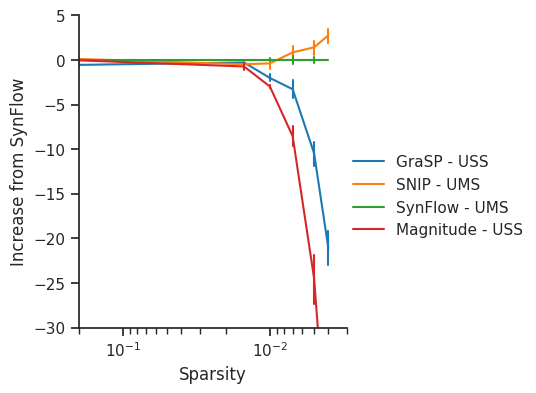

In [39]:
def baseline_query():
    mapping = {
        # "rand": "o1",
        "mag": "o1",
        "snip": "o10",
        "grasp": "o1",
        "synflow": "o10",
    }
    return " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])

df_besti = df.query(baseline_query()).query("init_strategy == 'standard'")

df_besti = df_besti.merge(df.query("phase_0_strategy == 'synflow' and type_short == 'o10'").query("init_strategy == 'standard'"), on=["init_strategy", "final_sparsity", "repeat_nr"], suffixes=(None, "_lth"))

INCREASE_COL = "Increase from SynFlow"

df_besti[INCREASE_COL] = df_besti["accuracy"] - df_besti["accuracy_lth"]

g = plot_perf(df_besti, col=None, hue=df_besti["phase_0_strategy"].apply(lambda x: transform_algos(x)) + " - " + df_besti["type_short"].apply(lambda x: transform_typeshort(x)), height = 4, aspect=1, y=INCREASE_COL)
g.set(
    xscale="log",
    ylim=(-30, 5),
    xlim=(0.2, 0.003)
)
savefig(g, "5_ablation_study_best_o")

# Ensemble Learning

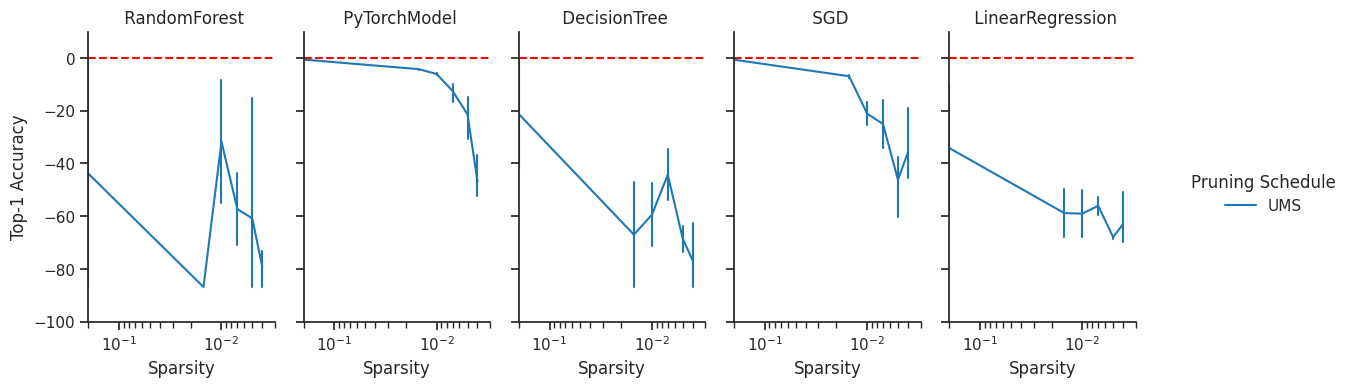

In [59]:

ensembles = ['PyTorchModel', 'RandomForest', 'SGD', 'MLP', 'DecisionTree', 'AdaBoost', 'GradientBoosting', 'LinearRegression']

df = load_csv()
df_bl = df.query(f"phase_0_strategy in {ensembles}").query("init_strategy == 'standard' and type_short == 'o10'")

df_fullytrained = df.query('final_sparsity == 1.0')[["init_strategy", "accuracy", "total_iterations", "total_epochs"]].groupby(["init_strategy"]).mean()

df_bl = df_bl.merge(df_fullytrained, on=["init_strategy"], how="inner", suffixes=((None, "_fullyTrained")))
df_bl["absolute_accuracy"] = df_bl["accuracy"]
df_bl["accuracy"] = df_bl["accuracy"] - df_bl["accuracy_fullyTrained"]
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)

# g = sns.relplot(data=prettify_names(df_bl), x=pretty_names["final_sparsity"], y=pretty_names["accuracy"], palette="tab10", kind="line",err_style="bars", col=pretty_names["phase_0_strategy"], hue="type_short")
g = plot_perf(df_bl, facet_kws={"margin_titles":True, "despine":False}, col_order = None)
for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(0.2, 0.003),
    ylim=(-100, 10),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, "5_ensemble_accuracy_drop")

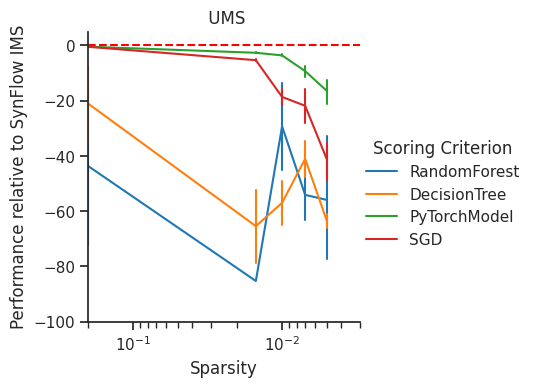

In [47]:
zero_algo = "synflow"
zero_type = "i10"
INCREASE_COL = f"Performance relative to {transform_algos(zero_algo)} {transform_typeshort(zero_type)}"

df = load_csv().query("init_strategy == 'standard'")


ensembles = ['PyTorchModel', 'RandomForest', 'SGD', 'MLP', 'DecisionTree', 'AdaBoost', 'GradientBoosting']
df_ensembles = df.query(f"phase_0_strategy in {ensembles} and type_short == 'o10'")

df_baseline = df.query(f"phase_0_strategy == '{zero_algo}' and type_short == '{zero_type}'")

df_ensembles = df_ensembles.merge(df_baseline, on=["init_strategy", "final_sparsity"], suffixes=(None, "_snipi10"))


df_ensembles[INCREASE_COL] = df_ensembles["accuracy"] - df_ensembles["accuracy_snipi10"]

g = plot_perf(data=df_ensembles, x="final_sparsity", y=INCREASE_COL, col="type_short", hue="phase_0_strategy", height = 4, aspect=1, col_order=None)

for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xscale="log",
    xlim=(0.2, 0.003),
    ylim=(-100, 5),
)
savefig(g, f"5_ensemble_increase_to_{zero_algo}{zero_type}")

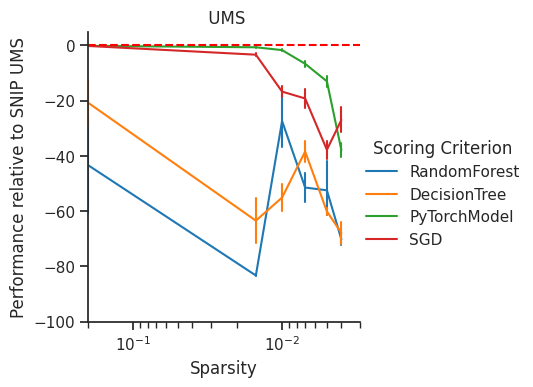

In [48]:
zero_algo = "snip"
zero_type = "o10"
INCREASE_COL = f"Performance relative to {transform_algos(zero_algo)} {transform_typeshort(zero_type)}"

df = load_csv().query("init_strategy == 'standard'")


ensembles = ['PyTorchModel', 'RandomForest', 'SGD', 'MLP', 'DecisionTree', 'AdaBoost', 'GradientBoosting']
df_ensembles = df.query(f"phase_0_strategy in {ensembles} and type_short == 'o10'")

df_baseline = df.query(f"phase_0_strategy == '{zero_algo}' and type_short == '{zero_type}'")

df_ensembles = df_ensembles.merge(df_baseline, on=["init_strategy", "final_sparsity"], suffixes=(None, "_snipi10"))


df_ensembles[INCREASE_COL] = df_ensembles["accuracy"] - df_ensembles["accuracy_snipi10"]

g = plot_perf(data=df_ensembles, x="final_sparsity", y=INCREASE_COL, col="type_short", hue="phase_0_strategy", height = 4, aspect=1, col_order=None)

for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xscale="log",
    xlim=(0.2, 0.003),
    ylim=(-100, 5),
)
savefig(g, f"5_ensemble_increase_to_{zero_algo}{zero_type}")

# Stacked Scoring

In [64]:
from itertools import product
stacked_basis = ["SynFlow", "SNIP", "GraSP", "Mag", "Rand"]
stackeds = [f"{a}{b}Stacked" for a, b in product(stacked_basis, stacked_basis)]

df = load_csv()
df = df.query("init_strategy == 'standard'")

import re

def get_algo(s, i):
    try:
        return re.match(f"({'|'.join(stacked_basis)})({'|'.join(stacked_basis)})Stacked", s)[i].lower()
    except:
        return None

df["algo_a"] = df["phase_0_strategy"].apply(lambda x:  get_algo(x, 1))
df["algo_b"] = df["phase_0_strategy"].apply(lambda x:  get_algo(x, 2))


# baselines
mapping = {
    "rand": "o1",
    "mag": "o1",
    "snip": "o10",
    "grasp": "o1",
    "synflow": "o10",
}
isBaseline = " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])

df["is_baseline"] = df.eval(isBaseline)

stacked_basis = ["SynFlow", "SNIP", "GraSP", "Mag", "Rand"]
stackeds = [f"{a}{b}Stacked" for a, b in product(stacked_basis, stacked_basis)]
df["is_stacked"] = df.eval(f'phase_0_strategy in {stackeds} and type_short == "o10"')

## compared to fully connected

/tmp/ipykernel_239248/74420975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl["algo_a"] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/74420975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl["algo_b"] = "None"


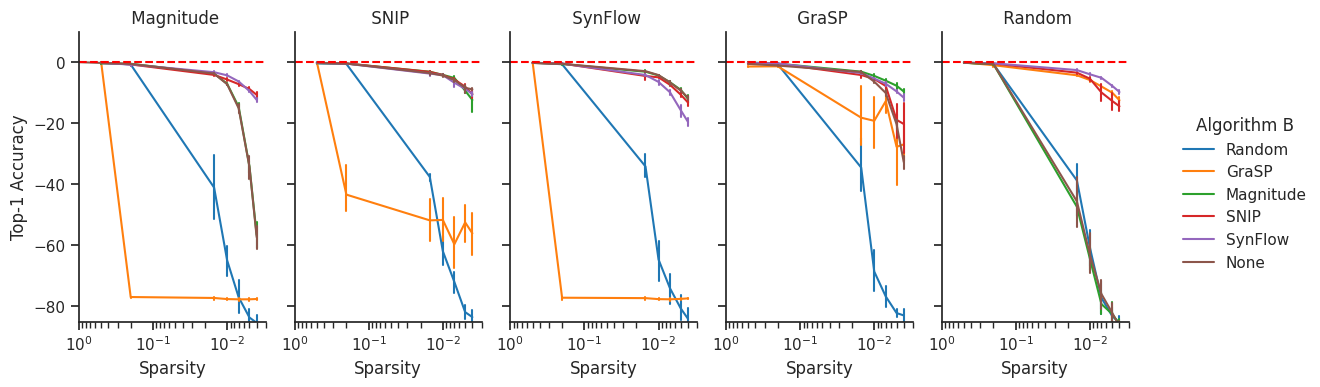

In [67]:
df_stacked = df.query("is_stacked")


df_bl = df.query("is_baseline")
df_bl["algo_a"] = df_bl["phase_0_strategy"]
df_bl["algo_b"] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_fullytrained = df.query('final_sparsity == 1.0')[["init_strategy", "accuracy", "total_iterations", "total_epochs"]].groupby(["init_strategy"]).mean()
df_combi = df_combi.merge(df_fullytrained, on=["init_strategy"], how="inner", suffixes=((None, "_fullyTrained")))
df_combi["absolute_accuracy"] = df_combi["accuracy"]
df_combi["accuracy"] = df_combi["accuracy"] - df_combi["accuracy_fullyTrained"]


import seaborn as sns
sns.set_theme(style="ticks", rc=custom_params)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}

# g = sns.relplot(data=df_combi, x="final_sparsity", y="accuracy", col="algo_a", hue="algo_b", facet_kws={"margin_titles":True, "despine":False, "legend_out":False,}, col_order = None, kind="line", err_style="bars", palette="tab10", height=4, aspect=.6)

df_combi["Algorithm A"] = df_combi["algo_a"].apply(lambda x: transform_algos(x))
df_combi["Algorithm B"] = df_combi["algo_b"].apply(lambda x: transform_algos(x))
g = plot_perf(df_combi, facet_kws={"margin_titles":True, "despine":False}, col="Algorithm A", hue="Algorithm B", col_order = None,)
for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(1, 0.003),
    ylim=(-85, 10),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, "5_stacked_accuracy_drop")

## increase to just algorithm A

/tmp/ipykernel_239248/3632590678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[COL] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/3632590678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[HUE] = "None"


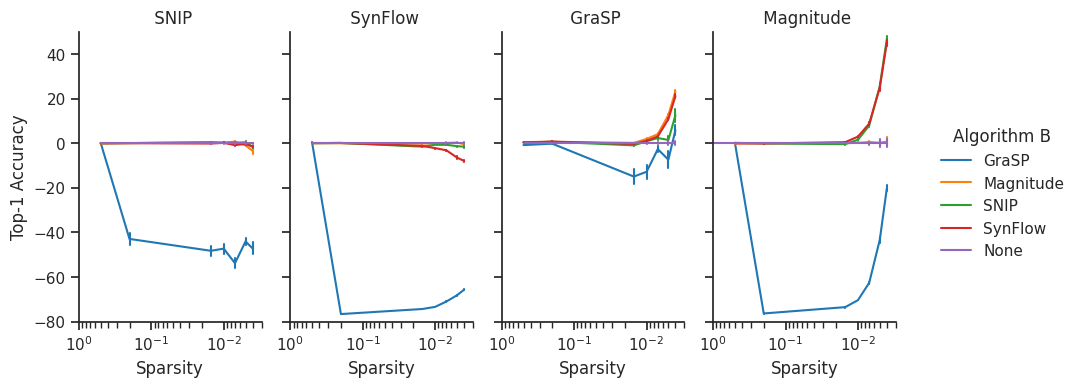

In [74]:
COL = "algo_a"
HUE = "algo_b"

df_stacked = df.query("is_stacked")

df_bl = df.query("is_baseline")
df_bl[COL] = df_bl["phase_0_strategy"]
df_bl[HUE] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_combi = df_combi.query(f"{COL} != 'rand'")
df_combi = df_combi.query(f"{HUE} != 'rand'")

# df_fullytrained = df.query('final_sparsity == 1.0')[["init_strategy", "accuracy", "total_iterations", "total_epochs"]].groupby(["init_strategy"]).mean()
df_combi = df_combi.merge(df_bl, on=["init_strategy", "final_sparsity", COL], how="left", suffixes=((None, "_fullyTrained")))

df_combi["accuracy"] = df_combi["accuracy"] - df_combi["accuracy_fullyTrained"]

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)
    
# g = sns.relplot(data=df_combi, x="final_sparsity", y="relative_accuracy", col=COL, hue=HUE, facet_kws={"margin_titles":True, "despine":False, "legend_out":False,}, col_order = None, kind="line",  palette="tab10", height=4, aspect=.6)
# for ax in g.axes_dict.values():
#     ax.axhline(0, ls='--', c="red")

df_combi["Algorithm A"] = df_combi["algo_a"].apply(lambda x: transform_algos(x))
df_combi["Algorithm B"] = df_combi["algo_b"].apply(lambda x: transform_algos(x))
g = plot_perf(df_combi, facet_kws={"margin_titles":True, "despine":False}, col="Algorithm A", hue="Algorithm B", col_order = None,)

g.set(
    xlim=(1, 0.003),
    ylim=(-80, 50),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, f"5_stacked_accuracy_drop_to_just_{COL}")

## just B

/tmp/ipykernel_239248/2960526508.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[COL] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/2960526508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[HUE] = "None"


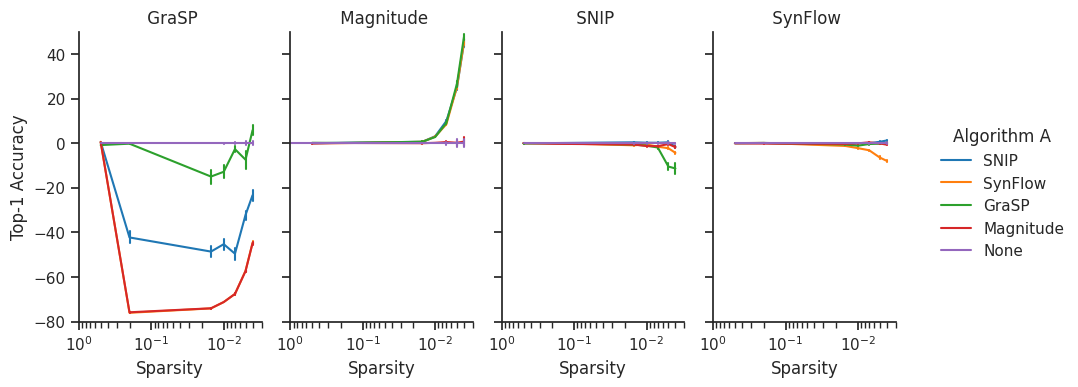

In [73]:
COL = "algo_b"
HUE = "algo_a"

df_stacked = df.query("is_stacked")

df_bl = df.query("is_baseline")
df_bl[COL] = df_bl["phase_0_strategy"]
df_bl[HUE] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_combi = df_combi.query(f"{COL} != 'rand'")
df_combi = df_combi.query(f"{HUE} != 'rand'")

# df_fullytrained = df.query('final_sparsity == 1.0')[["init_strategy", "accuracy", "total_iterations", "total_epochs"]].groupby(["init_strategy"]).mean()
df_combi = df_combi.merge(df_bl, on=["init_strategy", "final_sparsity", COL], how="left", suffixes=((None, "_fullyTrained")))

df_combi["accuracy"] = df_combi["accuracy"] - df_combi["accuracy_fullyTrained"]

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)
    
# g = sns.relplot(data=df_combi, x="final_sparsity", y="relative_accuracy", col=COL, hue=HUE, facet_kws={"margin_titles":True, "despine":False, "legend_out":False,}, col_order = None, kind="line",  palette="tab10", height=4, aspect=.6)
df_combi["Algorithm A"] = df_combi["algo_a"].apply(lambda x: transform_algos(x))
df_combi["Algorithm B"] = df_combi["algo_b"].apply(lambda x: transform_algos(x))
g = plot_perf(df_combi, facet_kws={"margin_titles":True, "despine":False}, col="Algorithm B", hue="Algorithm A", col_order = None,)

# for ax in g.axes_dict.values():
#     ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(1, 0.003),
    ylim=(-80, 50),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, f"5_stacked_accuracy_drop_to_just_{COL}")

## Compared to just o10 snip

/tmp/ipykernel_239248/3061236418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[COL] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/3061236418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[HUE] = "None"


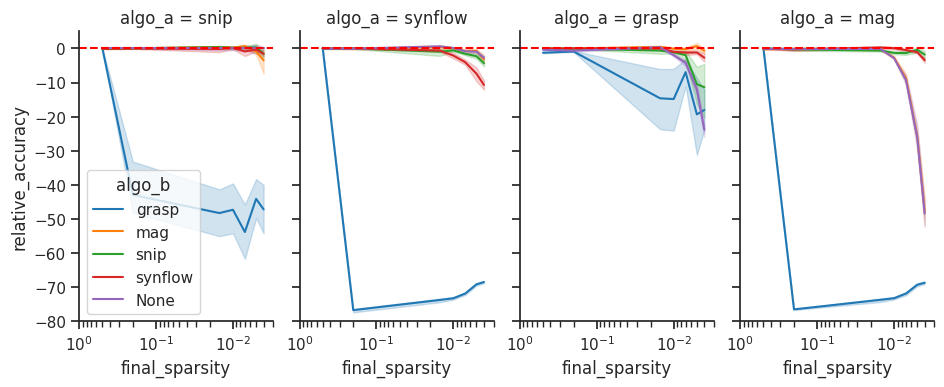

In [53]:
COL = "algo_a"
HUE = "algo_b"

df_stacked = df.query("is_stacked")

df_bl = df.query("is_baseline")
df_bl[COL] = df_bl["phase_0_strategy"]
df_bl[HUE] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_combi = df_combi.query(f"{COL} != 'rand'")
df_combi = df_combi.query(f"{HUE} != 'rand'")

df_snipo10 = df.query('phase_0_strategy == "snip" and type_short == "o10"').groupby(["final_sparsity", "init_strategy"]).mean()
df_combi = df_combi.merge(df_snipo10, on=["init_strategy", "final_sparsity"], how="left", suffixes=((None, "_fullyTrained")))

df_combi["relative_accuracy"] = df_combi["accuracy"] - df_combi["accuracy_fullyTrained"]

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)
    
g = sns.relplot(data=df_combi, x="final_sparsity", y="relative_accuracy", col=COL, hue=HUE, facet_kws={"margin_titles":True, "despine":False, "legend_out":False,}, col_order = None, kind="line",  palette="tab10", height=4, aspect=.6)
for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(1, 0.003),
    ylim=(-80, 5),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, f"5_stacked_accuracy_drop_to_snipo10")

/tmp/ipykernel_239248/2923086347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[COL] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/2923086347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[HUE] = "None"


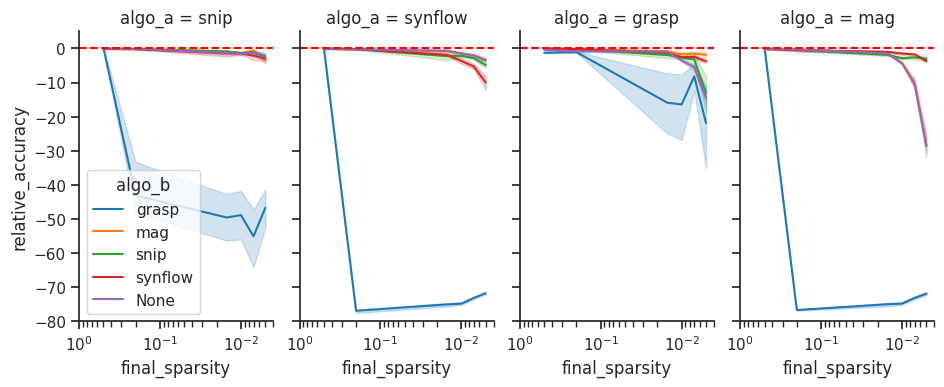

In [54]:
COL = "algo_a"
HUE = "algo_b"

df_stacked = df.query("is_stacked")

df_bl = df.query("is_baseline")
df_bl[COL] = df_bl["phase_0_strategy"]
df_bl[HUE] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_combi = df_combi.query(f"{COL} != 'rand'")
df_combi = df_combi.query(f"{HUE} != 'rand'")

df_snipi10 = df.query('phase_0_strategy == "snip" and type_short == "i10"').groupby(["final_sparsity", "init_strategy"]).mean()
df_combi = df_combi.merge(df_snipi10, on=["init_strategy", "final_sparsity"], how="left", suffixes=((None, "_fullyTrained")))

df_combi["relative_accuracy"] = df_combi["accuracy"] - df_combi["accuracy_fullyTrained"]

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(2,2)}
sns.set_theme(style="ticks", rc=custom_params)
    
g = sns.relplot(data=df_combi, x="final_sparsity", y="relative_accuracy", col=COL, hue=HUE, facet_kws={"margin_titles":True, "despine":False, "legend_out":False,}, col_order = None, kind="line",  palette="tab10", height=4, aspect=.6)
for ax in g.axes_dict.values():
    ax.axhline(0, ls='--', c="red")

g.set(
    xlim=(1, 0.004),
    ylim=(-80, 5),
    xscale="log",
    )
# plt.ticklabel_format(style='plain', axis='x')

savefig(g, f"5_stacked_accuracy_drop_to_snipo10")

Results Table

/tmp/ipykernel_239248/3025963643.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[COL] = df_bl["phase_0_strategy"]
/tmp/ipykernel_239248/3025963643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl[HUE] = "None"


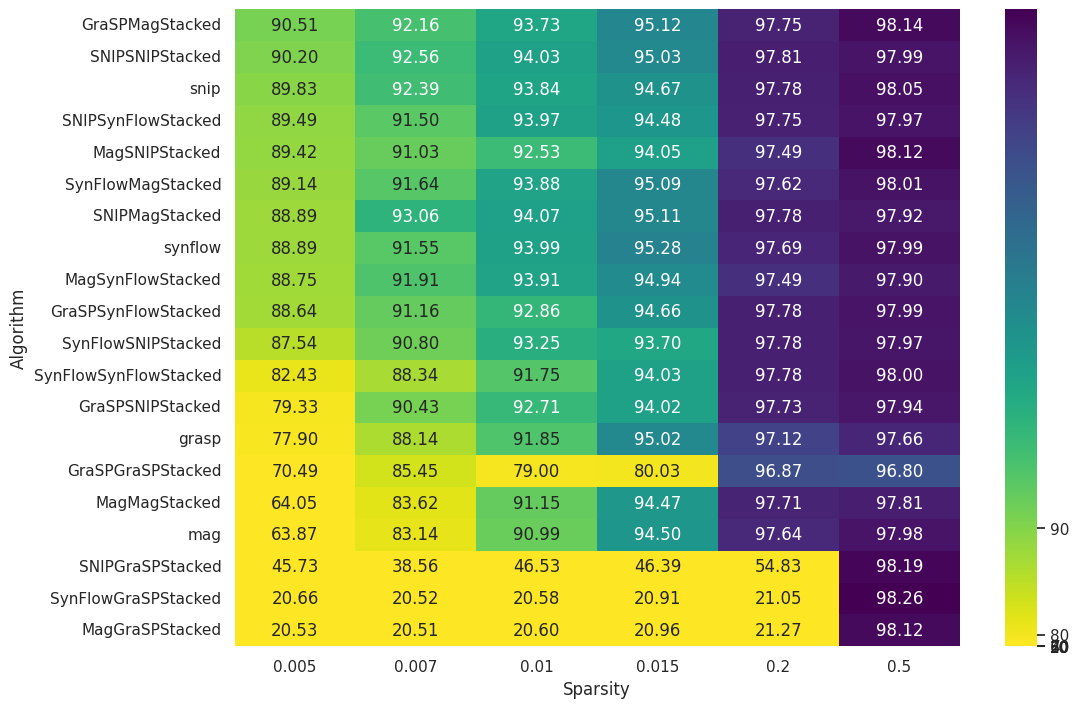

In [55]:
COL = "algo_a"
HUE = "algo_b"

df_stacked = df.query("is_stacked")

df_bl = df.query("is_baseline")
df_bl[COL] = df_bl["phase_0_strategy"]
df_bl[HUE] = "None"

df_combi = pd.concat([df_stacked, df_bl])

df_combi = df_combi.query(f"{COL} != 'rand'")
df_combi = df_combi.query(f"{HUE} != 'rand'")

df_grouped = df_combi[["phase_0_strategy", "phase_0_sparsity", "init_strategy", "type_short", "accuracy"]].groupby(["phase_0_strategy", "phase_0_sparsity", "init_strategy", "type_short"]).agg("mean").reset_index()
df_grouped = df_grouped.query("phase_0_sparsity not in [0.004, 1.0]")
# df_grouped
df_heatmap = df_grouped.pivot(index=["phase_0_strategy",], columns=["phase_0_sparsity"], values="accuracy").sort_values(by=0.005, ascending=False)

import seaborn as sns
from matplotlib.colors import PowerNorm, Normalize

sns.set(rc={'figure.figsize':(11.7,8.27)})

# df_heatmap = df_heatmap.reset_index().rename(columns={"phase_0_strategy": "Algorithm"}).set_index("Algorithm")
g = sns.heatmap(data=df_heatmap, cmap="viridis_r", norm=PowerNorm(15), annot=df_heatmap,  fmt=".2f")
g.set(xlabel='Sparsity', ylabel='Algorithm')
savefig(g, "5_stacked_fullresults_hm")


P-Test

In [56]:
baseline = "snip"
algos = ["GraSPMagStacked", "SNIPSNIPStacked"]


df_snip = df.query("is_baseline and phase_0_strategy == 'snip' and type_short == 'o10'")
df_algos = df.query(f"is_stacked and phase_0_strategy in {algos}")
df_merged = df_algos.merge(df_snip, on=["phase_0_sparsity", "base_model_id"], suffixes=(None, "_snip"))


# baseline = df_bl.query(f"phase_0_strategy == '{algo}'")
# stacked_1 = df_stacked.query(f"phase_0_strategy == 'SynFlowRandStacked'")

# ttest_ind(baseline["accuracy"], stacked_1["accuracy"])


from scipy.stats import ttest_ind

# algo = "snip"

# baseline = df_bl.query(f"phase_0_strategy == '{algo}'")
# stacked_1 = df_stacked.query(f"phase_0_strategy == 'SynFlowRandStacked'")

# ttest_ind(baseline["accuracy"], stacked_1["accuracy"])
p_values = df_merged.groupby(["phase_0_sparsity", "phase_0_strategy"]).apply(lambda df: ttest_ind(df['accuracy'], df['accuracy_snip']).pvalue).reset_index().query("phase_0_sparsity not in [0.004, 1.0]")
alpha = 0.05

p_values["relevant"] = p_values[0].apply(lambda x: f"{x:.3f}*" if x < alpha else f"{x:.3f}")
print(p_values.pivot(index= "phase_0_strategy", columns="phase_0_sparsity", values="relevant" ).to_latex())

\begin{tabular}{lllllll}
\toprule
phase\_0\_sparsity &  0.005 &  0.007 &  0.010 &  0.015 &   0.200 &  0.500 \\
phase\_0\_strategy &        &        &        &        &         &        \\
\midrule
GraSPMagStacked  &  0.398 &  0.842 &  0.353 &  0.785 &   0.099 &  0.238 \\
SNIPSNIPStacked  &  0.836 &  0.847 &  0.599 &  0.623 &  0.033* &  0.364 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_239248/922480027.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(p_values.pivot(index= "phase_0_strategy", columns="phase_0_sparsity", values="relevant" ).to_latex())


# Scores as inits

## Performance of fully connected

In [57]:
baselines = ["snip", "synflow", "grasp", "mag", "rand"]

df = load_csv()

df = df.query("final_sparsity == 1")

df_grouped = df.query("init_strategy == 'standard'").groupby(["init_strategy", "repeat_nr"]).mean()[["accuracy"]].reset_index()

df = df.query("init_strategy != 'standard'").groupby(["init_strategy", "repeat_nr"]).mean()[["accuracy"]].reset_index()
df = df.merge(df_grouped, on=["repeat_nr"], suffixes=(None, "_standard"))

from scipy.stats import ttest_ind

# df = df.merge(df_grouped.query("init_strategy == 'standard'"), on=["repeat_nr", "final_sparsity"], suffixes=(None, "_standard"))

df_p = df.groupby("init_strategy").apply(lambda df: ttest_ind(df['accuracy'], df['accuracy_standard']).pvalue).reset_index()#.query("phase_0_sparsity not in [0.004, 1.0]")
alpha = 0.05

print(pd.concat([df.groupby("init_strategy").mean()[["accuracy"]].merge(df_p, on="init_strategy").rename(columns={0:"p-value"}), df_grouped.groupby("init_strategy").mean().reset_index()]).set_index("init_strategy").sort_values(by="accuracy", ascending=False)[["accuracy"]].to_latex())


\begin{tabular}{lr}
\toprule
{} &   accuracy \\
init\_strategy &            \\
\midrule
standard      &  98.235000 \\
snip          &  97.863333 \\
bi-modal      &  97.810000 \\
synflow       &  96.596667 \\
grasp         &  80.833333 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_239248/188585560.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([df.groupby("init_strategy").mean()[["accuracy"]].merge(df_p, on="init_strategy").rename(columns={0:"p-value"}), df_grouped.groupby("init_strategy").mean().reset_index()]).set_index("init_strategy").sort_values(by="accuracy", ascending=False)[["accuracy"]].to_latex())


In [58]:
baselines = ["snip", "synflow", "grasp", "mag", "rand"]

df = load_csv()

df_grouped = df.groupby(["init_strategy", "repeat_nr", "final_sparsity"]).mean()[["accuracy"]].reset_index()

# df["accuracy_standard"] = df.query("init_strategy == 'standard'")["accuracy"]


from scipy.stats import ttest_ind

df = df.merge(df_grouped.query("init_strategy == 'standard'"), on=["repeat_nr", "final_sparsity"], suffixes=(None, "_standard"))

df = df.groupby(["phase_0_sparsity", "init_strategy", "phase_0_strategy"]).apply(lambda df: ttest_ind(df['accuracy'], df['accuracy_standard']).pvalue).reset_index().query("phase_0_sparsity not in [0.004, 1.0]")
alpha = 0.05


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
